### 1. Import modules

In [2]:
from collections import deque
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC

### 2. Data preprocessing functions

This includes
- Converting dates to timestamps
- Calculating all the Gustas things for the previous _n_ games

In [14]:
METRICS = {
    "GoalsFullTime": ("FTHG", "FTAG"),
    "GoalsHalfTime": ("HTHG", "HTAG"),
    "GustasPoints":  ("HomePoints", "AwayPoints"),
    "GoalShots":     ("HS",   "AS"),
    "TargetShots":   ("HST",  "AST"),
    "Corners":       ("HC",   "AC"),
    "YellowCards":   ("HY",   "AY"),
    "RedCards":      ("HR",   "AR")
}


def create_date_stamp(date_string: str) -> int:
    # Transforms a dd/mm/yy or dd/mm/yyyy string to a timestamp
    if len(date_string.split("/")[-1]) == 4:
        return int(datetime.strptime(date_string, "%d/%m/%Y").timestamp())
    else:
        return int(datetime.strptime(date_string, "%d/%m/%y").timestamp())


def group_seasons(df: pd.DataFrame) -> np.array:
    # Adds a column to the df indicating which season it is
    seasons = []
    season_counter = 1
    prev_season_index = 0
    rows = df.iterrows()
    next(rows)

    for i, game in rows:
        if game.Date[4] == "8" and df.iloc[i - 1].Date[4] == "5":
            seasons += [season_counter]*(i - prev_season_index)
            season_counter += 1
            prev_season_index = i

    return pd.DataFrame({"Season": seasons})


def generate_gustas_points(df: pd.DataFrame) -> pd.DataFrame:
    # Caluclate Gustas' points for each game
    points = {"HomePoints": [0]*len(df), "AwayPoints": [0]*len(df)}
    score_map = {"H": (3, 0), "A": (0, 3), "D": (1, 1)}

    for i, (_, game) in enumerate(df.iterrows()):
        points["HomePoints"][i], points["AwayPoints"][i] = score_map[game["FTR"]]

    return pd.DataFrame(points)


# Generating season-specific and game-specific data #



def sum_data_over_window(df: pd.DataFrame, teams: [str], scale: bool) -> {str : {str : float}}:
    # Takes the sum of each metric for each team from a given dataframe
    # args
    # - df: the data frame to take the sum over (either n-window or season)
    # - teams: all participating teams
    # - scale: whether to scale the result to the size of the window
    #
    # returns:
    #   for each metric, for each team, the metric for that team
    global METRICS
    metric_sums = {}

    for metric in METRICS:
        metric_by_team = {}
        home_metric, away_metric = METRICS[metric]

        for team in teams:
            home_games = df[df["HomeTeam"] == team]
            away_games = df[df["AwayTeam"] == team]
            metric_by_team[team] = home_games[home_metric].sum() + away_games[away_metric].sum()

        if scale:
            metric_sums[metric] = {team : m / len(df) for team, m in metric_by_team.items()}
        else:
            metric_sums[metric] = metric_by_team

    return metric_sums


def generate_previous_season_stats(curr: pd.DataFrame, prev: pd.DataFrame, teams: [str]) -> pd.DataFrame:
    # Includes the metrics for the previous season in each game of the current
    # args:
    # - curr: the current season
    # - prev: the previous season
    # - teams: the list of all teams
    # 
    # returns
    # A dataframe whose columns are named 'HomePST{metric}' and 'AwayPST{metric}'
    prev_season_metrics = sum_data_over_window(prev, teams, False)
    metrics_df = {}

    for metric in METRICS:
        metrics_df[f"HomePST{metric}"] = []
        metrics_df[f"AwayPST{metric}"] = []

    for metric in METRICS:
        for _, game in curr.iterrows():
            home = game["HomeTeam"]
            away = game["AwayTeam"]
            metrics_df[f"HomePST{metric}"].append(prev_season_metrics[metric][home])
            metrics_df[f"AwayPST{metric}"].append(prev_season_metrics[metric][away])

    df = pd.DataFrame(metrics_df)
    df.index = curr.index

    return df


def combine_previous_season_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Creates a dataframe that includes df and the stats from
    # the previous season
    new_df = None
    teams = df["HomeTeam"].unique()

    for i in range(1, int(df["Season"].max() + 1)):
        curr = df[df["Season"] == i]
        prev = df[df["Season"] == i - 1]
        res = generate_previous_season_stats(curr, prev, teams)

        if new_df is None:
            new_df = res
        else:
            new_df = pd.concat([new_df, res])

    return df.join(new_df)


def combine_last_n_games_stats(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # Generates and combines the stats for the last n games
    global METRICS

    teams = df["HomeTeam"].unique()
    metrics_df = {}

    # Fill column names
    for metric in METRICS:
        metrics_df[f"HomeLNG{metric}"] = [float("NaN")]*n
        metrics_df[f"AwayLNG{metric}"] = [float("NaN")]*n

    for i, (_, game) in enumerate(df.iterrows()):
        if i < n + 1:
            continue

        prev_window = df.iloc[i - n - 1 : i]
        prev_window_metrics = sum_data_over_window(prev_window, teams, True)

        for metric in METRICS:
            home = game["HomeTeam"]
            away = game["AwayTeam"]
            metrics_df[f"HomeLNG{metric}"].append(prev_window_metrics[metric][home])
            metrics_df[f"AwayLNG{metric}"].append(prev_window_metrics[metric][away])

    return pd.DataFrame(metrics_df)









def calculate_window_metrics_by_team(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # Calculates each metric for each team over the last n values
    global METRICS

    teams = df["HomeTeam"].unique()
    team_metric_deques = {t : {m : [0, deque([], maxlen=n)] for m in METRICS} for t in teams}
    metrics_df = {}

    # Fill columns
    for metric in METRICS:
        metrics_df[f"HomeLNG{metric}"] = []
        metrics_df[f"AwayLNG{metric}"] = []

    for _, game in df.iterrows():
        home = game.HomeTeam
        away = game.AwayTeam

        for metric in METRICS:
            home_metric, away_metric = METRICS[metric]

            # Add existing data to df
            home_metric_sum, home_deque = team_metric_deques[home][metric]
            away_metric_sum, away_deque = team_metric_deques[away][metric]

            if len(home_deque) == 0:
                metrics_df[f"HomeLNG{metric}"].append(float("NaN"))
            else:
                metrics_df[f"HomeLNG{metric}"].append(home_metric_sum / len(home_deque))

            if len(away_deque) == 0:
                metrics_df[f"AwayLNG{metric}"].append(float("NaN"))
            else:
                metrics_df[f"AwayLNG{metric}"].append(away_metric_sum / len(away_deque))

            # Include new data
            if len(home_deque) == n:
                team_metric_deques[home][metric][0] -= home_deque[0]
            
            if len(away_deque) == n:
                team_metric_deques[away][metric][0] -= away_deque[0]

            team_metric_deques[home][metric][0] += game[home_metric]
            team_metric_deques[home][metric][1].append(game[home_metric])

            team_metric_deques[away][metric][0] += game[away_metric]
            team_metric_deques[away][metric][1].append(game[away_metric])

    return pd.DataFrame(metrics_df)



# Only the below function should be used directly #


def format_df(df: pd.DataFrame) -> pd.DataFrame:
    # Applies all feature engineering etc that one could want
    df["DateStamp"] = df["Date"].map(create_date_stamp)
    df = df.join(group_seasons(df))
    df = df.join(generate_gustas_points(df))
    df = df.join(calculate_window_metrics_by_team(df, 10))

    return df
    

### 3. Load training and testing data

In [15]:
# Define features etc
FEATURES = [
    "HomeTeam",
    "AwayTeam",
    "Referee",
    "DateStamp",
#    "HomePSTGoalsFullTime",
#    "HomePSTGoalsHalfTime",
#    "HomePSTGustasPoints",
#    "HomePSTGoalShots",
#    "HomePSTTargetShots",
#    "HomePSTCorners",
#    "HomePSTYellowCards",
#    "HomePSTRedCards",
#    "AwayPSTGoalsFullTime",
#    "AwayPSTGoalsHalfTime",
#    "AwayPSTGustasPoints",
#    "AwayPSTGoalShots",
#    "AwayPSTTargetShots",
#    "AwayPSTCorners",
#    "AwayPSTYellowCards",
#    "AwayPSTRedCards",
    "HomeLNGGoalsFullTime",
    "HomeLNGGoalsHalfTime",
    "HomeLNGGustasPoints",
    "HomeLNGGoalShots",
    "HomeLNGTargetShots",
    "HomeLNGCorners",
    "HomeLNGYellowCards",
    "HomeLNGRedCards",
    "AwayLNGGoalsFullTime",
    "AwayLNGGoalsHalfTime",
    "AwayLNGGustasPoints",
    "AwayLNGGoalShots",
    "AwayLNGTargetShots",
    "AwayLNGCorners",
    "AwayLNGYellowCards",
    "AwayLNGRedCards",
]

CATEGORICAL_FEATURES = ["HomeTeam", "AwayTeam", "Referee"]

TARGET_NAMES = ["A", "D", "H"] # for presenting data


# Load datasets
df = format_df(pd.read_csv("data/epl-training.csv").dropna())

s13 = df[df.Season == 13]
print(len(s13))

print(df[df.Season == 13])
print(df[df.Season == 14])

df.fillna(0, inplace=True)
df["FTR"] = df["FTR"].astype(str)

for ft in CATEGORICAL_FEATURES:
    df[ft] = df[ft].astype(str)


# Split X and y, training and testing

X = df[FEATURES]
y = df["FTR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = [f for f in FEATURES if f not in CATEGORICAL_FEATURES]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



380
          Date   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
4560  18/08/12    Arsenal   Sunderland   0.0   0.0   D   0.0   0.0   D   
4561  18/08/12     Fulham      Norwich   5.0   0.0   H   2.0   0.0   H   
4562  18/08/12  Newcastle    Tottenham   2.0   1.0   H   0.0   0.0   D   
4563  18/08/12        QPR      Swansea   0.0   5.0   A   0.0   1.0   A   
4564  18/08/12    Reading        Stoke   1.0   1.0   D   0.0   1.0   A   
...        ...        ...          ...   ...   ...  ..   ...   ...  ..   
4935  19/05/13    Swansea       Fulham   0.0   3.0   A   0.0   1.0   A   
4936  19/05/13  Tottenham   Sunderland   1.0   0.0   H   0.0   0.0   D   
4937  19/05/13  West Brom   Man United   5.0   5.0   D   1.0   3.0   A   
4938  19/05/13   West Ham      Reading   4.0   2.0   H   2.0   0.0   H   
4939  19/05/13      Wigan  Aston Villa   2.0   2.0   D   2.0   1.0   H   

          Referee  ...  HomeLNGGoalShots  AwayLNGGoalShots  \
4560        C Foy  ...              14.7     

KeyError: "['HomePSTGoalsFullTime', 'HomePSTGoalsHalfTime', 'HomePSTGustasPoints', 'HomePSTGoalShots', 'HomePSTTargetShots', 'HomePSTCorners', 'HomePSTYellowCards', 'HomePSTRedCards', 'AwayPSTGoalsFullTime', 'AwayPSTGoalsHalfTime', 'AwayPSTGustasPoints', 'AwayPSTGoalShots', 'AwayPSTTargetShots', 'AwayPSTCorners', 'AwayPSTYellowCards', 'AwayPSTRedCards'] not in index"

### 4. Create SVM model

Specifically, we are going to fit our model to our data and then predict the testing results

In [144]:
clf = SVC(probability=False)
clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_test)

### 5. Get performance metrics

We're going to print a classification report and print some graphs and charts now

/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

              precision    recall  f1-score   support

           A       0.57      0.43      0.49       516
           D       0.00      0.00      0.00       460
           H       0.52      0.90      0.65       792

    accuracy                           0.53      1768
   macro avg       0.36      0.44      0.38      1768
weighted avg       0.40      0.53      0.44      1768



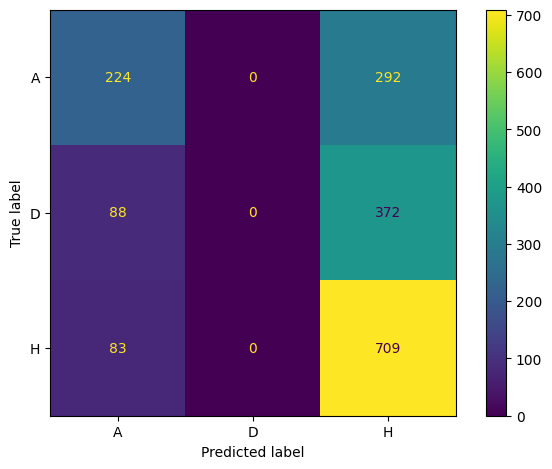

In [145]:
def evaluate_model(y_test, y_pred, target_names):
    print(classification_report(y_test, y_pred, target_names=target_names))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names)
    plt.tight_layout()
    plt.show()


evaluate_model(y_test, y_pred, TARGET_NAMES)